# Assignment 5.1: Transformer-based Sentiment Classification

In [2]:
import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)

print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)


TensorFlow: 2.19.0
Keras: 3.10.0


# 1: Correctly import the required libraries and the IMDB dataset

In [3]:
# ===== Task 1.2: Load IMDB dataset using load_dataset("imdb") =====
imdb = load_dataset("imdb")

print(imdb)
print("Train rows:", len(imdb["train"]))
print("Test rows :", len(imdb["test"]))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})
Train rows: 25000
Test rows : 25000


In [4]:
# ===== Task 1.3: Convert to pandas DataFrames and print sample sizes =====
train_df = pd.DataFrame(imdb["train"])
test_df  = pd.DataFrame(imdb["test"])

print("train_df shape:", train_df.shape)
print("test_df shape :", test_df.shape)

print("\nColumns:", train_df.columns.tolist())
print("\nTrain label distribution:\n", train_df["label"].value_counts())
print("\nTest label distribution:\n", test_df["label"].value_counts())


train_df shape: (25000, 2)
test_df shape : (25000, 2)

Columns: ['text', 'label']

Train label distribution:
 label
0    12500
1    12500
Name: count, dtype: int64

Test label distribution:
 label
0    12500
1    12500
Name: count, dtype: int64


In [5]:
# ===== Task 1.4: Preview a few samples =====
train_df.sample(10, random_state=42)


,text,label
6868,"Dumb is as dumb does, in this thoroughly unint...",0
24016,I dug out from my garage some old musicals and...,1
9668,After watching this movie I was honestly disap...,0
13640,This movie was nominated for best picture but ...,1
14018,Just like Al Gore shook us up with his painful...,1
7488,"Unfortunately, this movie is so bad. The origi...",0
5804,Altered Species starts one Friday night in Los...,0
12909,'The Luzhin Defence' is a movie worthy of anyo...,1
3386,This film's trailer interested me enough to wa...,0
9567,The only reason I watched this film was becaus...,0


# Section 2. Task 2: Exploratory Data Analysis and Preprocessing

       text_len_chars  text_len_words
count     25000.00000    25000.000000
mean       1325.06964      233.787200
std        1003.13367      173.733032
min          52.00000       10.000000
50%         979.00000      174.000000
90%        2617.00000      458.000000
95%        3432.05000      598.000000
99%        5213.01000      913.000000
max       13704.00000     2470.000000


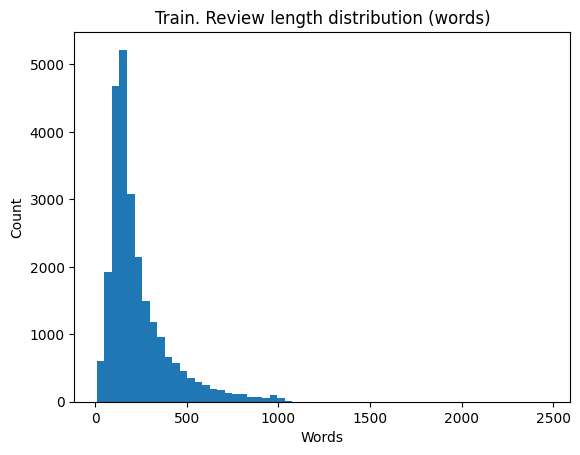

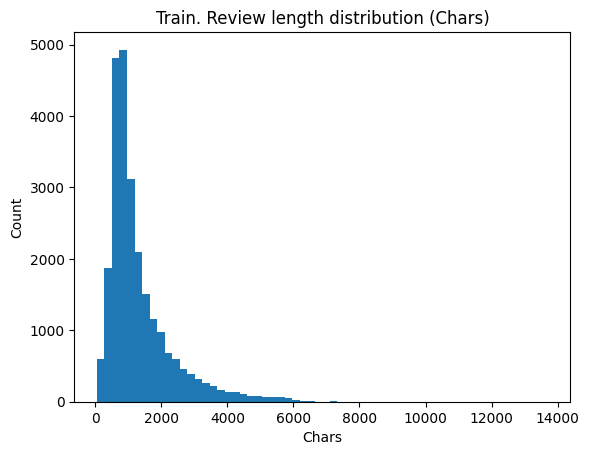

In [6]:
# ===== Task 2.1: Basic EDA =====
train_df["text_len_chars"] = train_df["text"].astype(str).apply(len)
train_df["text_len_words"] = train_df["text"].astype(str).apply(lambda x: len(x.split()))

print(train_df[["text_len_chars", "text_len_words"]].describe(percentiles=[0.5, 0.9, 0.95, 0.99]))

plt.figure()
plt.hist(train_df["text_len_words"], bins=60)
plt.title("Train. Review length distribution (words)")
plt.xlabel("Words")
plt.ylabel("Count")
plt.show()

plt.figure()
plt.hist(train_df["text_len_chars"], bins=60)
plt.title("Train. Review length distribution (Chars)")
plt.xlabel("Chars")
plt.ylabel("Count")
plt.show()


In [7]:
!pip install wordcloud

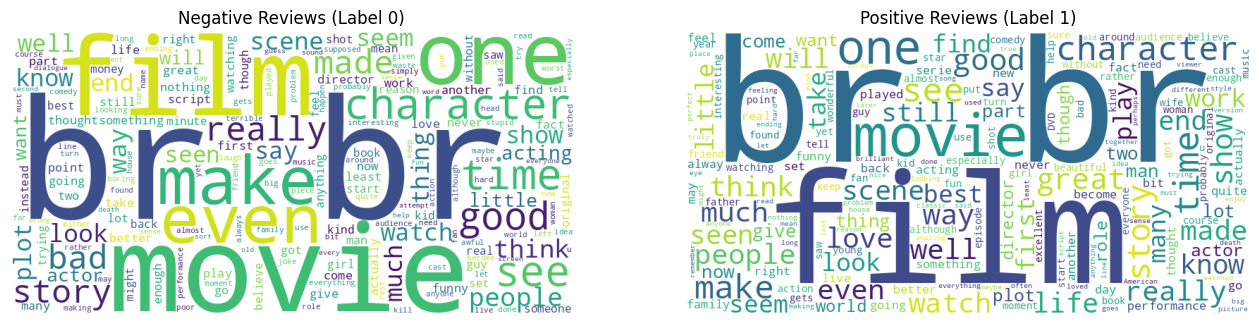

In [8]:

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine text for each class
neg_text = " ".join(train_df[train_df["label"] == 0]["text"].astype(str))
pos_text = " ".join(train_df[train_df["label"] == 1]["text"].astype(str))

# Generate word clouds
wc_neg = WordCloud(width=800, height=400, background_color="white").generate(neg_text)
wc_pos = WordCloud(width=800, height=400, background_color="white").generate(pos_text)

# Plot
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.imshow(wc_neg)
plt.title("Negative Reviews (Label 0)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(wc_pos)
plt.title("Positive Reviews (Label 1)")
plt.axis("off")

plt.show()


In [9]:
# ===== Task 2.2: Check a few very short and very long samples =====
print("Shortest reviews:")
display(train_df.sort_values("text_len_words").head(5)[["text", "label", "text_len_words"]])

print("\nLongest reviews:")
display(train_df.sort_values("text_len_words", ascending=False).head(5)[["text", "label", "text_len_words"]])


Shortest reviews:


,text,label,text_len_words
10925,This movie is terrible but it has some good ef...,0,10
2404,I wouldn't rent this one even on dollar rental...,0,10
373,You'd better choose Paul Verhoeven's even if y...,0,11
12114,Ming The Merciless does a little Bardwork and ...,0,12
17069,Adrian Pasdar is excellent is this film. He ma...,1,12



Longest reviews:


,text,label,text_len_words
13756,Match 1: Tag Team Table Match Bubba Ray and Sp...,1,2470
22551,Titanic directed by James Cameron presents a f...,1,1839
16948,**Attention Spoilers**<br /><br />First of all...,1,1830
16487,By now you've probably heard a bit about the n...,1,1723
15085,*!!- SPOILERS - !!*<br /><br />Before I begin ...,1,1601


In [10]:
# ===== Task 2.3: Cleaning function =====
html_break = re.compile(r"<br\s*/?>", flags=re.IGNORECASE)
multi_space = re.compile(r"\s+")

def clean_text(s: str) -> str:
    s = str(s)
    s = html_break.sub(" ", s)         # remove HTML line breaks
    s = s.lower()                      # lowercase
    s = re.sub(r"[^a-z0-9\s']", " ", s) # keep letters, numbers, space, apostrophe
    s = multi_space.sub(" ", s).strip()
    return s

# quick sanity check
examples = train_df["text"].head(3).tolist()
for i, ex in enumerate(examples, 1):
    print(f"\nExample {i} (raw):\n{ex[:250]}...")
    print(f"Example {i} (clean):\n{clean_text(ex)[:250]}...")



Example 1 (raw):
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a ...
Example 1 (clean):
i rented i am curious yellow from my video store because of all the controversy that surrounded it when it was first released in 1967 i also heard that at first it was seized by u s customs if it ever tried to enter this country therefore being a fan...

Example 2 (raw):
"I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn't matter what one's political views are because this film can hardly be taken seriously on any level. As for the claim that frontal male nudity is an automatic NC-17, that is...
Example 2 (clean):
i am curious yellow is a risible and pretentious steaming pile it doesn't matter what one's political views are because this film can hardly be taken seriously on a

In [11]:
# ===== Task 2.4: Apply cleaning to train and test =====
train_df["text_clean"] = train_df["text"].apply(clean_text)
test_df["text_clean"] = test_df["text"].apply(clean_text)

train_df[["text_clean", "label"]].head()


,text_clean,label
0,i rented i am curious yellow from my video sto...,0
1,i am curious yellow is a risible and pretentio...,0
2,if only to avoid making this type of film in t...,0
3,this film was probably inspired by godard's ma...,0
4,oh brother after hearing about this ridiculous...,0


In [12]:
# ===== Task 2.5: Split train into train/val =====
X = train_df["text_clean"].values
y = train_df["label"].values.astype(np.int32)

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val  :", X_val.shape, "y_val  :", y_val.shape)

print("\nTrain label distribution:", np.bincount(y_train))
print("Val label distribution  :", np.bincount(y_val))


X_train: (20000,) y_train: (20000,)
X_val  : (5000,) y_val  : (5000,)

Train label distribution: [10000 10000]
Val label distribution  : [2500 2500]


In [13]:
# ===== Task 2.6: Tokenization + padding =====
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

'''
Text → Word IDs → Fixed Length Matrix → Embedding → Transformer → Sentiment
Neural networks in practice want fixed-length inputs because batches must be rectangular tensors,
and Transformer operations like attention rely on batched matrix multiplications that need consistent
shapes for speed and simplicity.
'''

VOCAB_SIZE = 20000
MAX_LEN = 256

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="[OOV]")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq   = tokenizer.texts_to_sequences(X_val)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post", truncating="post")
X_val_pad   = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding="post", truncating="post")

print("X_train_pad:", X_train_pad.shape)
print("X_val_pad  :", X_val_pad.shape)
print("Example sequence:", X_train_seq[0][:25])
print("Example padded  :", X_train_pad[0][:25])


X_train_pad: (20000, 256)
X_val_pad  : (5000, 256)
Example sequence: [10, 25, 209, 77, 4, 673, 573, 1550, 7149, 10, 25, 106, 221, 29, 5, 2, 105, 549, 15, 779, 155, 246, 3, 2, 182]
Example padded  : [  10   25  209   77    4  673  573 1550 7149   10   25  106  221   29
    5    2  105  549   15  779  155  246    3    2  182]


In [14]:
# ===== Task 2.7: Prepare test sequences too (for later evaluation) =====
X_test = test_df["text_clean"].values
y_test = test_df["label"].values.astype(np.int32)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding="post", truncating="post")

print("X_test_pad:", X_test_pad.shape, "y_test:", y_test.shape)


X_test_pad: (25000, 256) y_test: (25000,)


In [15]:
# ===== Task 2.8: tf.data pipelines =====
'''
Converts arrays into TensorFlow dataset objects

Randomizes training data

Groups samples into batches

Optimizes training speed via prefetching
'''
BATCH_SIZE = 64

train_ds = tf.data.Dataset.from_tensor_slices((X_train_pad, y_train))
train_ds = train_ds.shuffle(20000, seed=42).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val_pad, y_val))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test_pad, y_test))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds, val_ds, test_ds


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

# Section 3. Task 3: Build a BASIC Transformer-based Sentiment Classifier

In [16]:
# ===== Task 3.1: Positional Embedding Layer =====
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen: int, vocab_size: int, embed_dim: int, **kwargs):
        super().__init__(**kwargs)
        self.maxlen = maxlen
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb   = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        # x: (batch, seq_len)
        seq_len = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=seq_len, delta=1)  # (seq_len,)
        positions = self.pos_emb(positions)                    # (seq_len, embed_dim)
        x = self.token_emb(x)                                  # (batch, seq_len, embed_dim)
        return x + positions                                    # broadcast add

    def get_config(self):
        cfg = super().get_config()
        cfg.update({
            "maxlen": self.maxlen,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return cfg


In [17]:
# ===== Task 3.2: Transformer Encoder Block =====
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, dropout: float = 0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.dropout_rate = dropout

        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout)
        self.dropout2 = layers.Dropout(dropout)

    def call(self, inputs, training=False):
        # Self-attention
        attn_output = self.att(inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        # Feed-forward network
        ffn_output = self.ffn(out1, training=training)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        cfg = super().get_config()
        cfg.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "dropout": self.dropout_rate,
        })
        return cfg


In [18]:
# ===== Task 3.3: Build Transformer Classifier Model =====
EMBED_DIM = 128
NUM_HEADS = 4
FF_DIM    = 256
DROPOUT   = 0.2

inputs = keras.Input(shape=(MAX_LEN,), dtype=tf.int32)

x = TokenAndPositionEmbedding(MAX_LEN, VOCAB_SIZE, EMBED_DIM)(inputs)
x = TransformerEncoder(EMBED_DIM, NUM_HEADS, FF_DIM, dropout=DROPOUT)(x)

# Pool sequence into a single vector
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(DROPOUT)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(DROPOUT)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding    │ (None, 256, 128)       │     2,592,768 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ (None, 256, 128)       │       330,240 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,931,329 (11.18 MB)

 Trainable params: 2,931,329 (11.18 MB)

 Non-trainable params: 0 (0.00 B)

# 4. Compile + Train

In [19]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[
        keras.metrics.BinaryAccuracy(name="accuracy"),
        keras.metrics.AUC(name="auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
    ],
)

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_auc", patience=2, mode="max", restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, min_lr=1e-5),
]

EPOCHS = 5

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 58ms/step - accuracy: 0.6485 - auc: 0.7092 - loss: 0.5898 - precision: 0.6495 - recall: 0.6623 - val_accuracy: 0.8828 - val_auc: 0.9529 - val_loss: 0.2932 - val_precision: 0.8669 - val_recall: 0.9044 - learning_rate: 0.0010
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9254 - auc: 0.9717 - loss: 0.2091 - precision: 0.9262 - recall: 0.9243 - val_accuracy: 0.8860 - val_auc: 0.9552 - val_loss: 0.2791 - val_precision: 0.9092 - val_recall: 0.8576 - learning_rate: 0.0010
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9668 - auc: 0.9915 - loss: 0.1049 - precision: 0.9720 - recall: 0.9616 - val_accuracy: 0.8772 - val_auc: 0.9477 - val_loss: 0.3281 - val_precision: 0.8655 - val_recall: 0.8932 - learning_rate: 0.0010
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9835 - auc: 0.9965 - loss: 0.0581 - precision: 0.9848 - recall: 0.9821 - val_accuracy: 0.8758 - val_auc: 0.9366 - val_loss: 0.4922 -

In [20]:
# ===== Task 4.1: Predict on test set =====
y_proba = model.predict(test_ds, verbose=0).ravel()
y_pred = (y_proba >= 0.5).astype(np.int32)

print("Pred shape:", y_pred.shape, "Proba shape:", y_proba.shape)
print("Positive prediction rate:", y_pred.mean())


Pred shape: (25000,) Proba shape: (25000,)
Positive prediction rate: 0.4436


In [21]:
# ===== Task 4.2: Compute evaluation metrics =====
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_proba)

metrics_df = pd.DataFrame([{
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1": f1,
    "ROC-AUC": auc
}])

metrics_df


,Accuracy,Precision,Recall,F1,ROC-AUC
0,0.8488,0.893147,0.7924,0.839763,0.935527


In [22]:
# ===== Task 4.3: Confusion matrix =====
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

cm_df = pd.DataFrame(
    [[tn, fp],
     [fn, tp]],
    index=["Actual 0 (neg)", "Actual 1 (pos)"],
    columns=["Pred 0 (neg)", "Pred 1 (pos)"]
)

cm_df


,Pred 0 (neg),Pred 1 (pos)
Actual 0 (neg),11315,1185
Actual 1 (pos),2595,9905


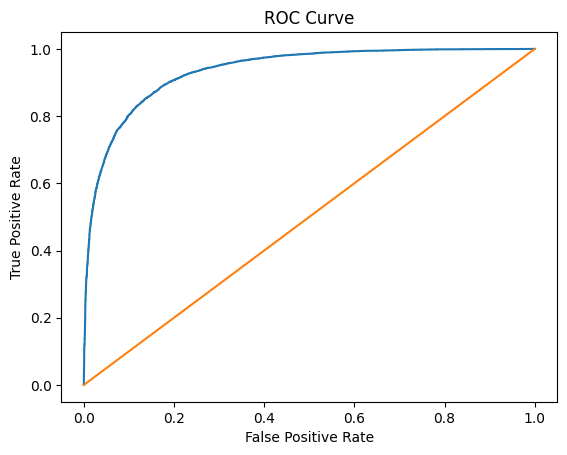

ROC-AUC: 0.9355267104


In [23]:
# ===== Task 4.4: ROC curve =====
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

print("ROC-AUC:", auc)


In [24]:
# ===== Task 4.5: Error analysis samples =====
test_view = test_df.copy()
test_view["proba_pos"] = y_proba
test_view["pred"] = y_pred
test_view["is_correct"] = (test_view["pred"].values == test_view["label"].values)

false_pos = test_view[(test_view["label"] == 0) & (test_view["pred"] == 1)].sort_values("proba_pos", ascending=False)
false_neg = test_view[(test_view["label"] == 1) & (test_view["pred"] == 0)].sort_values("proba_pos", ascending=True)

print("False positives (actual 0, predicted 1). Top confident:")
display(false_pos[["text", "text_clean", "label", "pred", "proba_pos"]].head(3))

print("\nFalse negatives (actual 1, predicted 0). Top confident:")
display(false_neg[["text", "text_clean", "label", "pred", "proba_pos"]].head(3))


False positives (actual 0, predicted 1). Top confident:


,text,text_clean,label,pred,proba_pos
8759,I loved this movie when it first came out(but ...,i loved this movie when it first came out but ...,0,1,0.997420
11770,"Based on the comments made so far, everyone se...",based on the comments made so far everyone see...,0,1,0.997223
8020,"This was my very first ""Bollywood"" movie and I...",this was my very first bollywood movie and i f...,0,1,0.996919



False negatives (actual 1, predicted 0). Top confident:


,text,text_clean,label,pred,proba_pos
23714,The Curse of Monkey Island. Released excactly ...,the curse of monkey island released excactly 6...,1,0,0.002918
20621,This was Laurel and Hardy's last silent film f...,this was laurel and hardy's last silent film f...,1,0,0.002925
14565,"Yes, indeed we have a winner- a winner in best...",yes indeed we have a winner a winner in best d...,1,0,0.002956


# Section 5. Save, Reload, and Run Inference

In [25]:
# ===== Task 5.1: Save model =====
SAVE_DIR = "sentiment_transformer_model"
os.makedirs(SAVE_DIR, exist_ok=True)

model_path = os.path.join(SAVE_DIR, "model.keras")
model.save(model_path)

print("Saved model to:", model_path)


Saved model to: sentiment_transformer_model/model.keras


In [26]:
# ===== Task 5.2: Save tokenizer =====
import json

tokenizer_path = os.path.join(SAVE_DIR, "tokenizer.json")
with open(tokenizer_path, "w", encoding="utf-8") as f:
    f.write(tokenizer.to_json())

meta_path = os.path.join(SAVE_DIR, "preprocess_meta.json")
meta = {
    "VOCAB_SIZE": VOCAB_SIZE,
    "MAX_LEN": MAX_LEN
}
with open(meta_path, "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2)

print("Saved tokenizer to:", tokenizer_path)
print("Saved meta to     :", meta_path)


Saved tokenizer to: sentiment_transformer_model/tokenizer.json
Saved meta to     : sentiment_transformer_model/preprocess_meta.json


In [27]:
# ===== Task 5.3: Reload model + tokenizer =====
from tensorflow.keras.preprocessing.text import tokenizer_from_json

reloaded_model = keras.models.load_model(
    model_path,
    custom_objects={
        "TokenAndPositionEmbedding": TokenAndPositionEmbedding,
        "TransformerEncoder": TransformerEncoder
    }
)

with open(tokenizer_path, "r", encoding="utf-8") as f:
    tok_json = f.read()
reloaded_tokenizer = tokenizer_from_json(tok_json)

with open(meta_path, "r", encoding="utf-8") as f:
    meta_loaded = json.load(f)

print("Reloaded meta:", meta_loaded)
reloaded_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'token_and_position_embedding', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'transformer_encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Reloaded meta: {'VOCAB_SIZE': 20000, 'MAX_LEN': 256}


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding    │ (None, 256, 128)       │     2,592,768 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ (None, 256, 128)       │       330,240 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,793,989 (33.55 MB)

 Trainable params: 2,931,329 (11.18 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,862,660 (22.36 MB)

In [28]:
# ===== Task 5.4: Single-text inference =====
def predict_sentiment(text: str, threshold: float = 0.5):
    text_c = clean_text(text)
    seq = reloaded_tokenizer.texts_to_sequences([text_c])
    pad = pad_sequences(seq, maxlen=meta_loaded["MAX_LEN"], padding="post", truncating="post")
    proba = float(reloaded_model.predict(pad, verbose=0).ravel()[0])
    label = 1 if proba >= threshold else 0
    return {
        "text_clean": text_c,
        "proba_positive": proba,
        "pred_label": label,
        "pred_class": "positive" if label == 1 else "negative"
    }

# Try a couple quick examples
print(predict_sentiment("This movie was fantastic. Great acting and story."))
print(predict_sentiment("Terrible film. Waste of time."))


{'text_clean': 'this movie was fantastic great acting and story', 'proba_positive': 0.9959763288497925, 'pred_label': 1, 'pred_class': 'positive'}
{'text_clean': 'terrible film waste of time', 'proba_positive': 0.002042679116129875, 'pred_label': 0, 'pred_class': 'negative'}


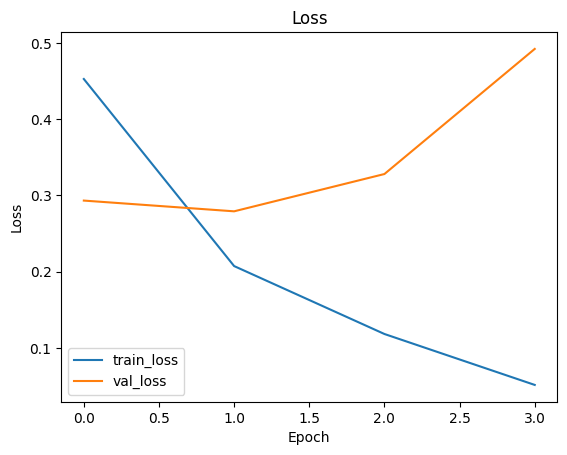

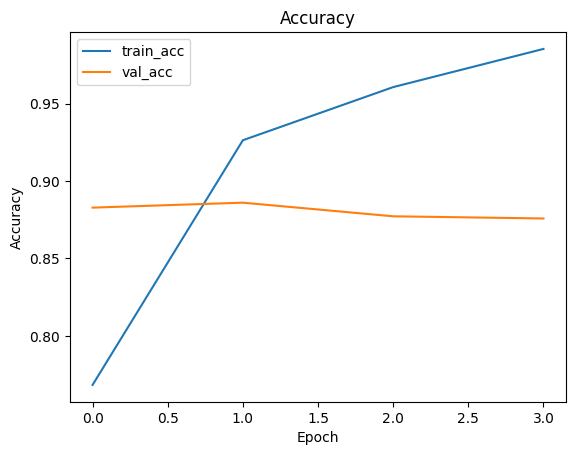

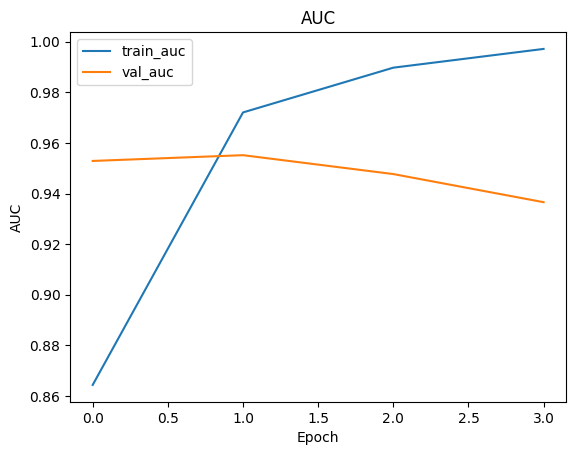

In [29]:
# ===== Task 5.5: Training curves =====
hist = pd.DataFrame(history.history)

plt.figure()
plt.plot(hist["loss"], label="train_loss")
plt.plot(hist["val_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
if "accuracy" in hist.columns:
    plt.plot(hist["accuracy"], label="train_acc")
    plt.plot(hist["val_accuracy"], label="val_acc")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

plt.figure()
if "auc" in hist.columns:
    plt.plot(hist["auc"], label="train_auc")
    plt.plot(hist["val_auc"], label="val_auc")
    plt.title("AUC")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.show()


# Section 6. Build two models and compare

In [30]:
def eval_binary_classifier(model, ds, y_true):
    y_proba = model.predict(ds, verbose=0).ravel()
    y_pred = (y_proba >= 0.5).astype(np.int32)

    row = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "ROC-AUC": roc_auc_score(y_true, y_proba),
    }
    return row, y_proba, y_pred


In [31]:
def build_basic_transformer(vocab_size=VOCAB_SIZE, maxlen=MAX_LEN, embed_dim=128, num_heads=2, ff_dim=256, dropout=0.1):
    inputs = keras.Input(shape=(maxlen,), dtype=tf.int32)

    # Token embedding only (no positional embedding)
    x = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)(inputs)

    # Simple Transformer block
    x = TransformerEncoder(embed_dim=embed_dim, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout)(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs, name="basic_transformer")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.BinaryAccuracy(name="accuracy"),
            keras.metrics.AUC(name="auc"),
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
        ],
    )
    return model

basic_model = build_basic_transformer(num_heads=2, dropout=0.1)
basic_model.summary()


Model: "basic_transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 256, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_1           │ (None, 256, 128)       │       198,400 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,766,721 (10.55 MB)

 Trainable params: 2,766,721 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Train BASIC for 5 epochs (per assignment)
basic_history = basic_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    verbose=1
)


Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.6717 - auc: 0.7365 - loss: 0.5777 - precision: 0.6688 - recall: 0.6673 - val_accuracy: 0.8742 - val_auc: 0.9535 - val_loss: 0.3180 - val_precision: 0.9216 - val_recall: 0.8180
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.9294 - auc: 0.9774 - loss: 0.1891 - precision: 0.9294 - recall: 0.9291 - val_accuracy: 0.8902 - val_auc: 0.9530 - val_loss: 0.2822 - val_precision: 0.8888 - val_recall: 0.8920
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.9675 - auc: 0.9924 - loss: 0.0998 - precision: 0.9702 - recall: 0.9648 - val_accuracy: 0.8772 - val_auc: 0.9444 - val_loss: 0.3558 - val_precision: 0.8824 - val_recall: 0.8704
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.9838 - auc: 0.9968 - loss: 0.0559 - precision: 0.9851 - recall: 0.9825 - val_accuracy: 0.8602 - val_auc: 0.9368 - val_loss: 0.4562 - val_precision: 0.9073 - val_recall: 0.8024
Epoch 5/5
313/313 ━━━━━━━━━━━━━

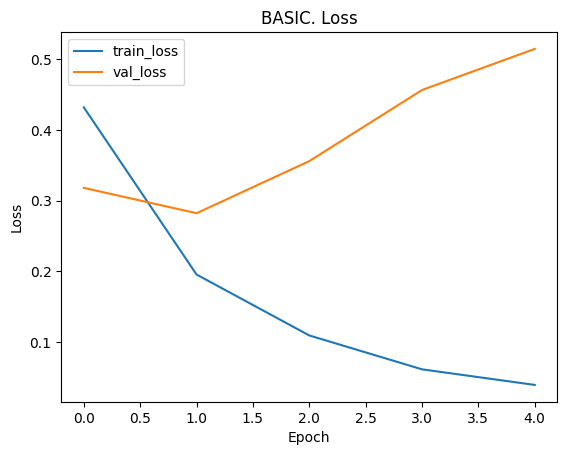

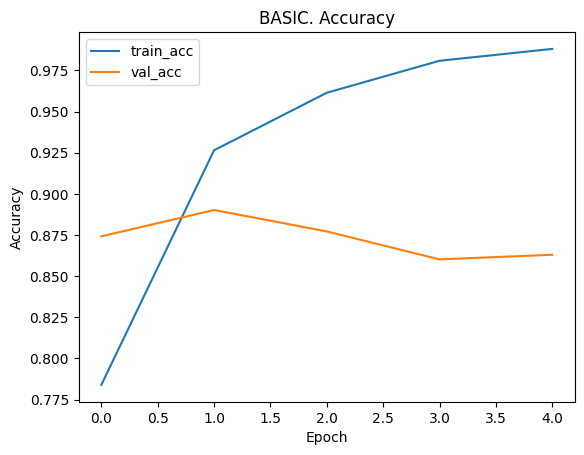

In [33]:
# Plot BASIC training curves (accuracy, loss)
bh = pd.DataFrame(basic_history.history)

plt.figure()
plt.plot(bh["loss"], label="train_loss")
plt.plot(bh["val_loss"], label="val_loss")
plt.title("BASIC. Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(bh["accuracy"], label="train_acc")
plt.plot(bh["val_accuracy"], label="val_acc")
plt.title("BASIC. Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [34]:
def build_advanced_transformer(vocab_size=VOCAB_SIZE, maxlen=MAX_LEN, embed_dim=128, num_heads=4, ff_dim=256, dropout=0.2):
    inputs = keras.Input(shape=(maxlen,), dtype=tf.int32)

    # Custom positional encoding layer (Token + Position)
    x = TokenAndPositionEmbedding(maxlen=maxlen, vocab_size=vocab_size, embed_dim=embed_dim)(inputs)

    # Transformer block with MHA >= 4 and dropout
    x = TransformerEncoder(embed_dim=embed_dim, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout)(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs, name="advanced_transformer")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.BinaryAccuracy(name="accuracy"),
            keras.metrics.AUC(name="auc"),
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
        ],
    )
    return model

advanced_model = build_advanced_transformer(num_heads=4, dropout=0.2)
advanced_model.summary()


Model: "advanced_transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_1  │ (None, 256, 128)       │     2,592,768 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_2           │ (None, 256, 128)       │       330,240 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,931,329 (11.18 MB)

 Trainable params: 2,931,329 (11.18 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Train ADVANCED for 5 epochs
advanced_history = advanced_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    verbose=1
)


Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 58ms/step - accuracy: 0.6477 - auc: 0.7092 - loss: 0.5970 - precision: 0.6452 - recall: 0.6293 - val_accuracy: 0.8812 - val_auc: 0.9501 - val_loss: 0.2870 - val_precision: 0.9059 - val_recall: 0.8508
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.9203 - auc: 0.9720 - loss: 0.2096 - precision: 0.9250 - recall: 0.9157 - val_accuracy: 0.8850 - val_auc: 0.9540 - val_loss: 0.2838 - val_precision: 0.8695 - val_recall: 0.9060
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9626 - auc: 0.9899 - loss: 0.1151 - precision: 0.9635 - recall: 0.9624 - val_accuracy: 0.8670 - val_auc: 0.9440 - val_loss: 0.4058 - val_precision: 0.9037 - val_recall: 0.8216
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.9825 - auc: 0.9955 - loss: 0.0624 - precision: 0.9823 - recall: 0.9828 - val_accuracy: 0.8696 - val_auc: 0.9317 - val_loss: 0.4912 - val_precision: 0.8952 - val_recall: 0.8372
Epoch 5/5
313/313 ━━━━━━━━━━

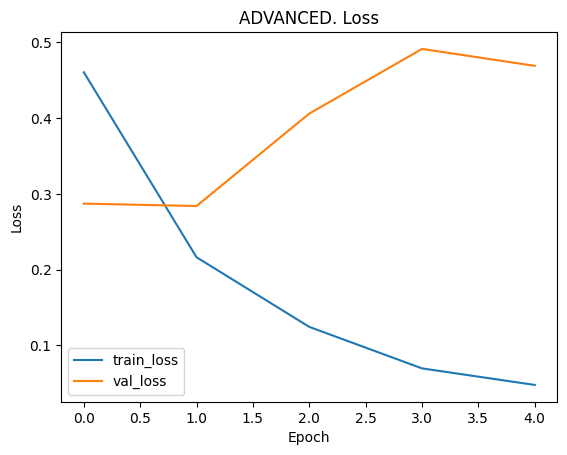

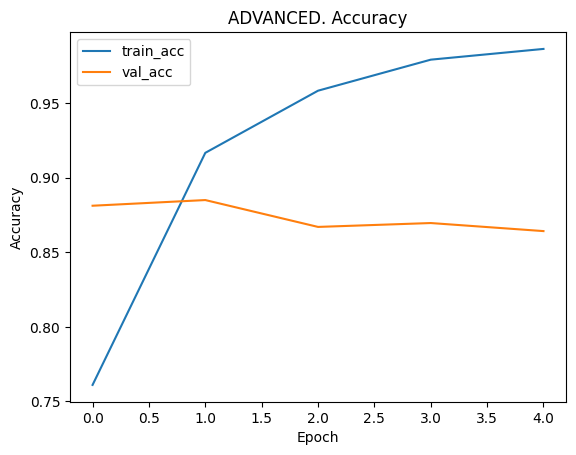

In [36]:
# Plot ADVANCED training curves (accuracy, loss)
ah = pd.DataFrame(advanced_history.history)

plt.figure()
plt.plot(ah["loss"], label="train_loss")
plt.plot(ah["val_loss"], label="val_loss")
plt.title("ADVANCED. Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(ah["accuracy"], label="train_acc")
plt.plot(ah["val_accuracy"], label="val_acc")
plt.title("ADVANCED. Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [37]:
basic_row, basic_proba, basic_pred = eval_binary_classifier(basic_model, test_ds, y_test)
adv_row,   adv_proba,   adv_pred   = eval_binary_classifier(advanced_model, test_ds, y_test)

compare_df = pd.DataFrame([
    {"Model": "Basic Transformer", **basic_row},
    {"Model": "Advanced Transformer", **adv_row},
]).set_index("Model")

compare_df


,Accuracy,Precision,Recall,F1,ROC-AUC
Model,,,,,
Basic Transformer,0.83220,0.840564,0.81992,0.830114,0.902417
Advanced Transformer,0.83328,0.860943,0.79496,0.826637,0.909293


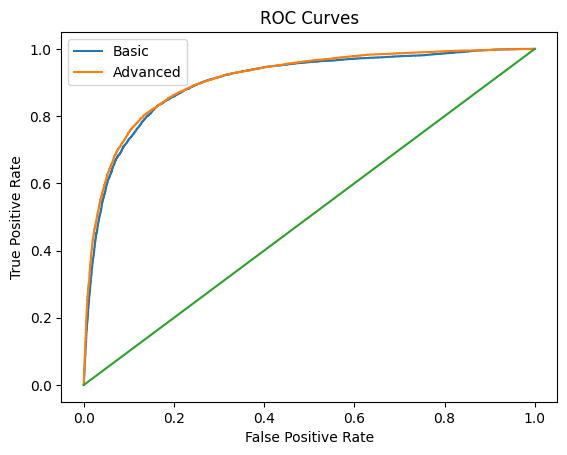

In [38]:
# Optional: ROC curves on one plot
basic_fpr, basic_tpr, _ = roc_curve(y_test, basic_proba)
adv_fpr, adv_tpr, _     = roc_curve(y_test, adv_proba)

plt.figure()
plt.plot(basic_fpr, basic_tpr, label="Basic")
plt.plot(adv_fpr, adv_tpr, label="Advanced")
plt.plot([0, 1], [0, 1])
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


| Feature | Basic Transformer | Advanced Transformer |
|----------|------------------|----------------------|
| Attention Mechanism | Learns attention | Learns attention with richer structure |
| Positional Encoding | No explicit positional encoding | Explicit positional encoding |
| Attention Complexity | Slightly simpler attention | More attention heads |
| Context Modeling | Standard contextual modeling | Better contextual modeling |
| Parameter Count | Slightly fewer parameters | Slightly more parameters |
| ROC-AUC | Lower | Higher |
| Recall (at 0.5 threshold) | Slightly more balanced recall | Slightly lower recall |
| Precision | Balanced precision | More precise predictions |


# Section 7. Results

In [39]:
# ===== Task 7.1: Add parameter counts to  comparison table =====
def count_params(m):
    return int(np.sum([np.prod(w.shape) for w in m.trainable_weights]))

compare_with_params = compare_df.copy()
compare_with_params["Trainable Params"] = [
    count_params(basic_model),
    count_params(advanced_model),
]

compare_with_params


,Accuracy,Precision,Recall,F1,ROC-AUC,Trainable Params
Model,,,,,,
Basic Transformer,0.83220,0.840564,0.81992,0.830114,0.902417,2766721
Advanced Transformer,0.83328,0.860943,0.79496,0.826637,0.909293,2931329


In [40]:
# ===== Task 7.3: Lightweight hyperparameter sweep (optional) =====
def train_and_eval_config(embed_dim, num_heads, ff_dim, dropout, epochs=2):
    m = build_advanced_transformer(
        embed_dim=embed_dim,
        num_heads=num_heads,
        ff_dim=ff_dim,
        dropout=dropout
    )
    m.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=0)
    # Evaluate on validation set with sklearn metrics
    yv_proba = m.predict(val_ds, verbose=0).ravel()
    yv_pred = (yv_proba >= 0.5).astype(np.int32)
    return {
        "embed_dim": embed_dim,
        "num_heads": num_heads,
        "ff_dim": ff_dim,
        "dropout": dropout,
        "val_auc": roc_auc_score(y_val, yv_proba),
        "val_f1": f1_score(y_val, yv_pred, zero_division=0),
        "val_acc": accuracy_score(y_val, yv_pred),
    }

configs = [
    (128, 4, 256, 0.2),
    (128, 4, 512, 0.2),
    (192, 4, 256, 0.2),
    (128, 6, 256, 0.2),
]

sweep_rows = []
for (ed, nh, fd, dr) in configs:
    row = train_and_eval_config(ed, nh, fd, dr, epochs=2)
    sweep_rows.append(row)

sweep_df = pd.DataFrame(sweep_rows).sort_values("val_auc", ascending=False)
sweep_df


,embed_dim,num_heads,ff_dim,dropout,val_auc,val_f1,val_acc
0,128,4,256,0.2,0.955143,0.885377,0.8854
3,128,6,256,0.2,0.954958,0.860390,0.8698
1,128,4,512,0.2,0.952772,0.885047,0.8790
2,192,4,256,0.2,0.952460,0.884414,0.8806


# explain Transformer design

“The movie was not good”

We’ll break this into three parts:

1. Core Transformer Components
2. Why Positional Encoding Matters
3. Why Multiple Attention Heads Matter



1️⃣ Transformer Encoder Design Overview


| Component             | What It Does                               | Shape Transformation                             | Why It Matters                                              | Example Effect                                    |
| --------------------- | ------------------------------------------ | ------------------------------------------------ | ----------------------------------------------------------- | ------------------------------------------------- |
| Token Embedding       | Converts word IDs into dense vectors       | (batch, seq_len) → (batch, seq_len, embed_dim)   | Turns discrete words into learnable numeric representations | “good” becomes a 128-dimensional vector           |
| Positional Embedding  | Adds word position information             | Added to token embeddings                        | Allows model to understand word order                       | Distinguishes “not good” from “good not”          |
| Multi-Head Attention  | Lets each word attend to all other words   | (batch, seq_len, embed_dim) → same shape         | Captures contextual relationships                           | “good” attends to “not”                           |
| Residual + LayerNorm  | Stabilizes training                        | Same shape                                       | Prevents gradient instability                               | Enables deeper architecture                       |
| Feed-Forward Network  | Applies nonlinear transformation per token | Same shape                                       | Refines representation after attention                      | Strengthens sentiment features                    |
| Pooling Layer         | Compresses sequence into one vector        | (batch, seq_len, embed_dim) → (batch, embed_dim) | Creates review-level summary                                | Converts full review into single sentiment vector |
| Final Dense + Sigmoid | Outputs probability                        | (batch, embed_dim) → (batch, 1)                  | Produces sentiment score                                    | 0.91 → Positive                                   |


2️⃣ Why Positional Encoding Is Critical


| Sentence                 | Word Order | Without Positional Encoding                   | With Positional Encoding               |
| ------------------------ | ---------- | --------------------------------------------- | -------------------------------------- |
| “The movie was good”     | Positive   | Model sees {the, movie, was, good}            | Understands correct sequence           |
| “The movie was not good” | Negative   | Model still sees {the, movie, was, not, good} | Understands that “not” modifies “good” |
| “Good not was movie the” | Nonsense   | Could look similar to first sentence          | Clearly different                      |


3️⃣ Why Multi-Head Attention Matters

Multi-head attention allows the model to learn different relational perspectives simultaneously.

Example sentence:

“The movie was not good but the acting was excellent.”

| Attention Head | What It Might Focus On | Example Relationship          |
| -------------- | ---------------------- | ----------------------------- |
| Head 1         | Negation detection     | “not” → “good”                |
| Head 2         | Contrast words         | “but” splits sentiment        |
| Head 3         | Positive adjectives    | “excellent” importance        |
| Head 4         | Long-range context     | Links “acting” to “excellent” |


Instead of one attention pattern, you get multiple parallel interpretations.

### More heads = richer representation.

Design Tradeoff Summary

| Design Choice            | Benefit                    | Cost                  | Business Impact         |
| ------------------------ | -------------------------- | --------------------- | ----------------------- |
| Add Positional Encoding  | Better order understanding | Small param increase  | Fewer context errors    |
| Increase Attention Heads | Richer contextual modeling | Slightly more compute | Better ranking (AUC)    |
| Add Dropout              | Better generalization      | Slight training noise | More stable predictions |


## Conceptual Summary

A Transformer works because:

  - Embeddings represent meaning
  - Positional encoding represents order
  - Multi-head attention represents relationships
  - Feed-forward layers refine features
  - Pooling converts sequence understanding into a decision

Together, this enables context-aware prediction instead of keyword matching.





## Transformer Sentiment Classifier Architecture




```
Input Text
     │
     ▼
Tokenization + Padding
     │
     ▼
Input Layer (batch, 256)
     │
     ▼
Token Embedding (batch, 256, 128)
     │
     ▼
+ Positional Embedding
     │
     ▼
Transformer Encoder Block
   ├── Multi-Head Self-Attention
   ├── Add & LayerNorm
   ├── Feed-Forward Network
   └── Add & LayerNorm
     │
     ▼
Global Average Pooling
     │
     ▼
Dense (ReLU)
     │
     ▼
Dropout
     │
     ▼
Dense (Sigmoid)
     │
     ▼
Sentiment Probability
```



# Extra: Hugging Face Transformers
Text → Pretrained Tokenizer → Pretrained BERT → Classification Head


In [ ]:
!pip install transformers datasets torch evaluate


In [42]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np

dataset = load_dataset("imdb")

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [43]:
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=256
    )

encoded_dataset = dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [44]:
encoded_dataset = encoded_dataset.remove_columns(["text"])
encoded_dataset = encoded_dataset.rename_column("label", "labels")
encoded_dataset.set_format("torch")


In [45]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [46]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    # evaluation_strategy="epoch", # TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    compute_metrics=compute_metrics,
)

In [47]:
trainer.train()


Step,Training Loss
500,0.336219
1000,0.272900
1500,0.256853
2000,0.185416
2500,0.167223
3000,0.164725


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

TrainOutput(global_step=3126, training_loss=0.22751318149969355, metrics={'train_runtime': 1323.2626, 'train_samples_per_second': 37.785, 'train_steps_per_second': 2.362, 'total_flos': 3311684966400000.0, 'train_loss': 0.22751318149969355, 'epoch': 2.0})

In [ ]:
trainer.train()


Step,Training Loss


In [ ]:
trainer.evaluate()
